In [71]:
from sklearn import tree
from sklearn.model_selection import cross_validate
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

#Prelievo dei dati per costruire il Decision Tree

data = pd.read_excel('.\\Data\\data.xlsx')
target = data['DE'].values
data = data.drop(['DIDA id', 'DE'], axis='columns') #drop degli id e delle classi effettive
data = data.sample(frac=1).reset_index(drop=True)

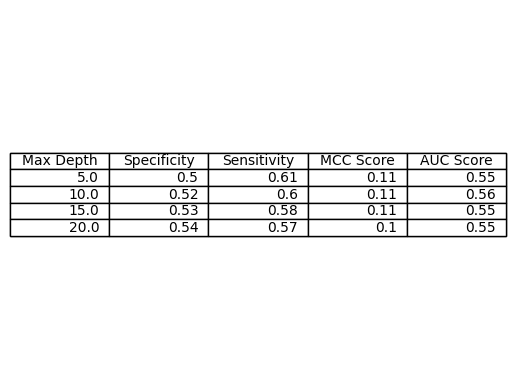

In [73]:
#Selezione della max depth migliore con cross validatio e metriche usate nell'articolo

specificity = make_scorer(recall_score, pos_label=0)
sensitivity = make_scorer(recall_score, pos_label=1)
mcc = make_scorer(matthews_corrcoef)
auc = make_scorer(roc_auc_score)
scoring = {'specificity': specificity, 'sensitivity': sensitivity, 'mcc': mcc, 'auc': auc}

#score conterrà le metriche da confrontare per ogni altezza
score = {'Max Depth': [], 'Specificity':[], 'Sensitivity': [], 'MCC Score': [], 'AUC Score': []} 
for i in [5,10,15,20]: #altezze massime testate
    albero = tree.DecisionTreeClassifier(min_samples_split=5, max_depth=i) 
    albero.fit(data, target) #creazione del modello
    scores = cross_validate(albero, data, target, cv= 10, scoring=scoring) #cross validation
    #di seguito, calcolo le metriche medie e le inserisco nel dizionario
    score['Max Depth'].append(i)
    score['Sensitivity'].append(round(scores['test_sensitivity'].mean(), 2))
    score['Specificity'].append(round(scores['test_specificity'].mean(), 2))
    score['MCC Score'].append(round(scores['test_mcc'].mean(), 2))
    score['AUC Score'].append(round(scores['test_auc'].mean(), 2))
   
table_df = pd.DataFrame(score) #creo un dataset dal dizionario score per stampare la tabella

fig, ax = plt.subplots()
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
table = ax.table(cellText=table_df.values, colLabels = table_df.columns, loc='center')
ax.add_table(table)
plt.show() #stampa della tabella con le metriche per ogni altezza massima testata

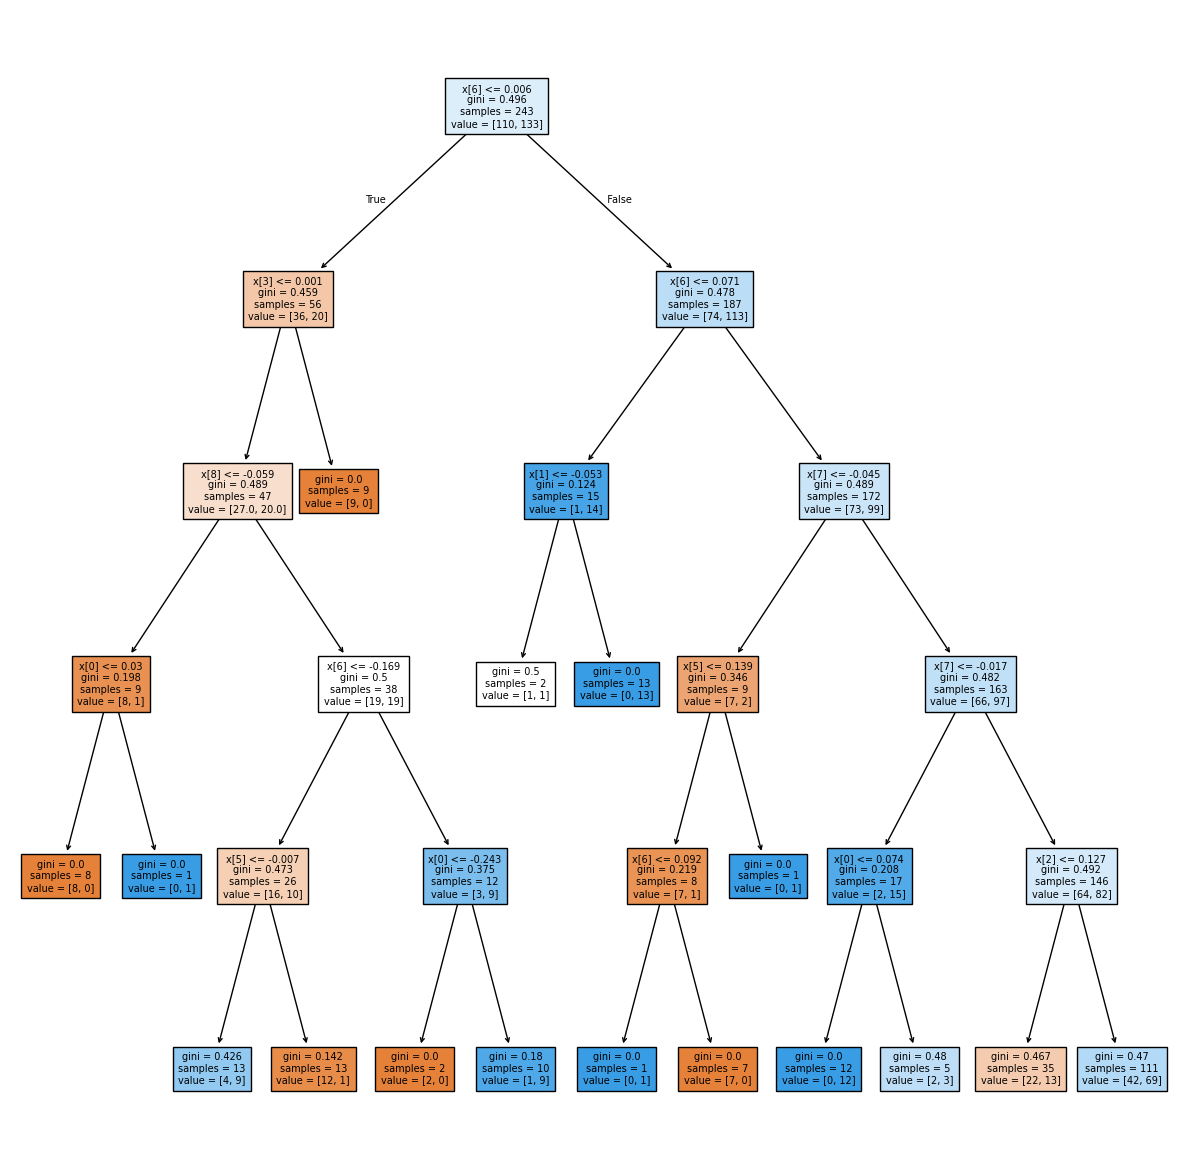

In [65]:
#Una volta scelta la max_depth, costruisco il modello e lo plotto
albero = tree.DecisionTreeClassifier(min_samples_split=5, max_depth=5)
albero.fit(data.values, target)
plt.figure(figsize=(15,15))
res = tree.plot_tree(albero, fontsize=7, filled=True)

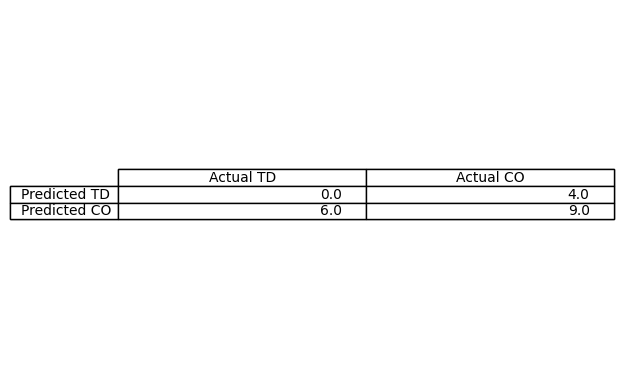

In [75]:
import numpy as np

#Test del decision tree sul dataset di test

test = pd.read_excel('.\\Data\\test.xlsx')
test.columns = map(lambda str: str.strip(), test.columns) #rimozione degli spazi dal nome delle colonne
target = test['DE']
test = test.drop(columns=['DE'], axis='columns') 

conf_matrix = np.zeros((2,2)) #Matrice di confusione
for i in range(0, test.shape[0]):
    res = albero.predict(test.iloc[i].values.reshape(1, -1)) #predizione sull'istanza i
    #Costruzione della matrice di confusione
    if res == 1 and target[i] == 1: #TP
        conf_matrix[0][0] += 1
    elif res == 1 and target[i] == 0: #FP
        conf_matrix[0][1] += 1
    elif res == 0 and target[i] == 0: #TN
        conf_matrix[1][0] += 1
    else: #FN
        conf_matrix[1][1] += 1
        
fig, ax = plt.subplots()
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
table = ax.table(cellText=conf_matrix, rowLabels= ['Predicted TD', 'Predicted CO'], colLabels = ['Actual TD', 'Actual CO'], loc='center')
ax.add_table(table)

plt.show() #stampa della matrice di confusione